In [1]:
import gym
import time
from functools import reduce
import argparse
import collections
import numpy as np
import pandas as pd
from gym import spaces
import matplotlib.pylab as plt

In [2]:
Experience = collections.namedtuple(typename='Experience', \
                                                    field_names=['state', 'action', 'reward', 'done', 'nextState'])

In [3]:
from IPython.display import clear_output
class OptiFunctionEnv(gym.Env):
    def __init__(self):
        super(OptiFunctionEnv, self).__init__()
        """
        Description: y = x^{2} 的⽬标函数，希望求得能够使得⽬标函数最⼩的x。
        Source: This code corresponds to the version of the cart-pole problem described by
        https://github.com/openai/gym/blob/master/gym/envs/classic_control/cartpole.py
        """
        self.action_space = spaces.Discrete(2) # 设置动作空间：0, 1。表示向左向右。
        self.length = 5
        self.high = np.array([self.length]) # 状态空间边界范围为5。
        
        # 设置状态空间范围：-high到high，类型为int32
        self.observation_space = spaces.Box(-self.high, self.high, dtype=np.int32)
        self.state = None
        self.count = 0
    
    def func(self, x):
        return np.power(x, 2)
    
    def step(self, action):
        """
        给定动作，在环境中进⾏状态转移
         :param action:
         :return:
         """
        err_msg = "{} ({}) invalid".format(action, type(action))
        assert self.action_space.contains(action), err_msg
        self.count += 1
        pre_state = self.state
        self.state += 1 if action else -1
        done = bool(self.state < -self.length or self.state > self.length or self.count >= 20)
        
        if done:
            reward = -(self.func(self.state) - self.func(pre_state))
        else:
            reward = -(self.func(self.state) - self.func(pre_state))
        return self.state, reward, done, {}
    
    def reset(self):
        """
        初始化环境状态
         :return:
         """
        self.count = 0
        self.state = np.random.choice([self.observation_space.low[0],
        self.observation_space.high[0]])
        return self.state
    
    def render(self, mode='human'):
        clear_output(True)
        x = np.linspace(-self.length, self.length, 100) 
        y = [self.func(i) for i in x]
        plt.cla()
        plt.plot(x, y, 'r', linewidth=2)
        plt.scatter(self.state, self.func(self.state), linewidth=10)
        plt.title("Find the solution corresponding to the minimum objective value")
        plt.pause(0.1)
    
    def close(self):
        pass

In [4]:
class ExperienceBuffer:
    def __init__(self, args):
        self.buffer = collections.deque(maxlen=args.replay_size)
        
    def __len__(self):
        return len(self.buffer)
    
    def append(self, experience):
        self.buffer.append(experience)
    
    def sample(self, batch_size):
        """
        randomly sample the batch of transitions from the replay buffer.
        :param batch_size:
        :return:
        """
        indices = np.random.choice(len(self.buffer), batch_size, replace=False)
        states, actions, rewards, dones, next_states = zip(*[self.buffer[idx] for idx in indices])
        return np.array(states), np.array(actions), np.array(rewards, dtype=np.float32), \
                                                                                dones, np.array(next_states)
    
    def sample_last(self):
        """
        sample the last transitions from the replay buffer.
        :return:
        """
        indices = [len(self.buffer) - 1]
        states, actions, rewards, dones, next_states = zip(*[self.buffer[idx] for idx in indices])
        return states[0], actions[0], rewards[0], dones[0], next_states[0]

In [5]:
class Agent(object):
    def __init__(self, env, exp_buffer, args):
        """
        初始化智能体
        :param env:
        :param exp_buffer:
        :param args:
        """
        self.env = env
        self.exp_buffer = exp_buffer
        self.q_table = self.build_model()
        self.args = args
    
    def build_model(self):
        """
        构建智能体模型
         :return:
         """
        obs_index = list(range(self.env.observation_space.low[0], self.env.observation_space.high[0] + 1))
        q_table = pd.DataFrame(np.random.random((len(obs_index), self.env.action_space.n)), obs_index,
        list(range(self.env.action_space.n)))
        return q_table
    
    def choose_action(self, state):
        """
        根据环境观测值选择动作的机制
        :param state:
        :return:
        """
        state_action = self.q_table.loc[state, :]
        if np.random.uniform() > self.args.epsilon or (state_action == 0).all():
            action_name = np.random.choice(self.q_table.columns.values)
        else:
            action_name = state_action.idxmax()
        return action_name
    
    def store_transition(self, state, action, r, done, state_next):
        """
        存储轨迹
        :param state:
        :param action:
        :param r:
        :param done:
        :param state_next:
        :return:
        """
        exp = Experience(state, action, r, done, state_next)
        self.exp_buffer.append(exp)
        
    def learn(self):
        """
        更新智能体模型
        :return:
        """
        buffer = self.exp_buffer.sample_last()
        state, action, r, done, next_state = buffer
        if done:
            delta = r - self.q_table.loc[state, action]
        else:
            delta = r + self.args.gamma * self.q_table.iloc[next_state, :].max() - self.q_table.loc[state, action]
        self.q_table.loc[state, action] += self.args.lr * delta
        return None

In [6]:
def main():
    parser = argparse.ArgumentParser(description="The parameter of Q-Learning")
    parser.add_argument("--replay_size", type=int, help="maximum capacity of the buffer", default=10000)
    parser.add_argument("--gamma", type=float, help="gamma value used for Bellman approximation", default=0.95)
    parser.add_argument("--lr", type=float, help="learning rate used in the Adam optimizer", default=0.1)
    parser.add_argument("--epsilon", type=float, help="epsilon for greedy", default=0.9)
    args = parser.parse_args(args=[])
                    
    buffer = ExperienceBuffer(args=args)
    env = OptiFunctionEnv()
    agent = Agent(env, buffer, args)

    for epoch in range(10000):
        state, done = env.reset(), False # 1. 获取初始状态信息
        episode_r = []
        while not done:
            env.render()
            action = agent.choose_action(state) # 2. 依据状态选择动作
            state_next, r, done, info = env.step(action) # 3. 依据动作更新环境状态
            agent.store_transition(state, action, r, done, state_next)
            agent.learn() # 4. 智能体进⾏学习
            if not done:
                state = state_next # 5. 更新状态
            episode_r.append(r)
        print("epoch: {} | len_ep_r: {} | avg_r: {}".format(epoch, len(episode_r), \
                                                                np.sum(episode_r) / len(episode_r)))
    env.close()

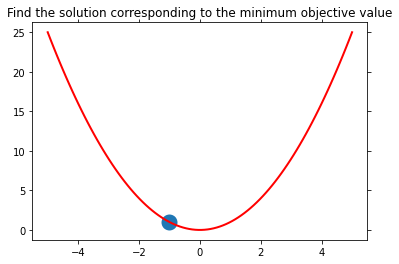

KeyboardInterrupt: 

In [7]:
if __name__ == '__main__':
    main()